# GHS/USD Exchange Rate Prediction using XGBoost

This notebook implements an XGBoost model to predict the buying price of the Ghanaian Cedi (GHS) against the US Dollar (USD) using historical exchange rates and economic indicators.

## 1. Data Loading and Required Libraries

First, we'll import the necessary libraries and load our dataset.

In [6]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings('ignore')

# Set style for visualizations
# plt.style.use('viridis')
sns.set_palette("husl")

In [7]:
# Load the dataset
df = pd.read_csv('datasets/cleaned/merged_fx_dataset.csv')

# Display basic information about the dataset
print("Dataset Info:")
print("-" * 50)
print(df.info())

Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3703 entries, 0 to 3702
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  3703 non-null   object 
 1   Buying                3703 non-null   float64
 2   Selling               3701 non-null   float64
 3   MidRate               3701 non-null   float64
 4   MPR                   3703 non-null   float64
 5   FoodInflation         3703 non-null   float64
 6   GhInflationRate       3703 non-null   float64
 7   NonFoodInflation      3703 non-null   float64
 8   BrentOil              3703 non-null   float64
 9   Cocoa                 3703 non-null   float64
 10  Gold                  3703 non-null   float64
 11  GhInterestRate        3703 non-null   float64
 12  NetForeignAssets      3703 non-null   float64
 13  NIR                   3703 non-null   float64
 14  Imports

## 2. Data Preprocessing and Feature Engineering

Let's prepare our data for modeling by:
1. Converting date column to datetime
2. Setting date as index
3. Checking and handling missing values
4. Creating lag features for time series analysis

In [8]:
# Convert date column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [9]:
# Check for missing values
print("Missing Values:")
print("-" * 50)
print(df.isnull().sum())

# Handle missing values using forward fill method
df = df.ffill()

# Create lag features (previous 5 days)
for i in range(1, 6):
    df[f'buying_rate_lag_{i}'] = df['Buying'].shift(i)

# Create rolling mean features
df['rolling_mean_7d'] = df['Buying'].rolling(window=7).mean()
df['rolling_mean_30d'] = df['Buying'].rolling(window=30).mean()

# Create rolling standard deviation features
df['rolling_std_7d'] = df['Buying'].rolling(window=7).std()
df['rolling_std_30d'] = df['Buying'].rolling(window=30).std()

# Drop rows with NaN values created by lag features
df = df.dropna()

print("\nDataset shape after feature engineering:", df.shape)

Missing Values:
--------------------------------------------------
Buying                  0
Selling                 2
MidRate                 2
MPR                     0
FoodInflation           0
GhInflationRate         0
NonFoodInflation        0
BrentOil                0
Cocoa                   0
Gold                    0
GhInterestRate          0
NetForeignAssets        0
NIR                     0
Imports                 0
Exports                 0
GhGDP                   0
GhCompositeIndex        0
FXDeposits              0
InterbankWeightedAvg    0
T-bill-182              0
T-bill-91               0
PrivateSectorCredit     0
TradeBalance            0
USGDP                   0
USInflationRate         0
USInterestRate          0
dtype: int64

Dataset shape after feature engineering: (3674, 35)


## 3. Data Splitting and Model Development

Now we'll:
1. Split our features and target variable
2. Create train and test sets
3. Scale our features
4. Initialize and train our XGBoost model

In [10]:
# Prepare features and target
target = 'Buying'
features = [col for col in df.columns if col != target]

X = df[features]
y = df[target]

# Split the data into training and testing sets (keeping last 20% for testing)
split_idx = int(len(df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize XGBoost model with basic parameters
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Train the model
model.fit(
    X_train_scaled,
    y_train,
    verbose=True
)

print("\nModel training completed!")


Model training completed!


## 4. Model Evaluation and Performance Analysis

Let's evaluate our model's performance using various metrics and visualizations:

Model Performance Metrics:
--------------------------------------------------
RMSE: 0.1987
MAE: 0.1347
R2 Score: 0.1554


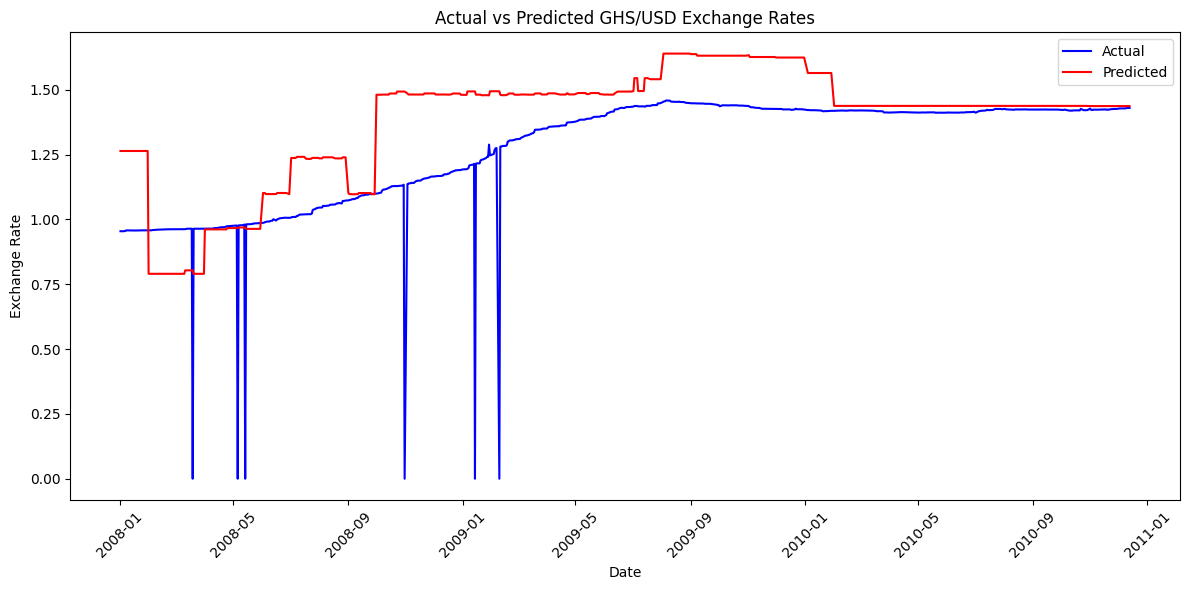

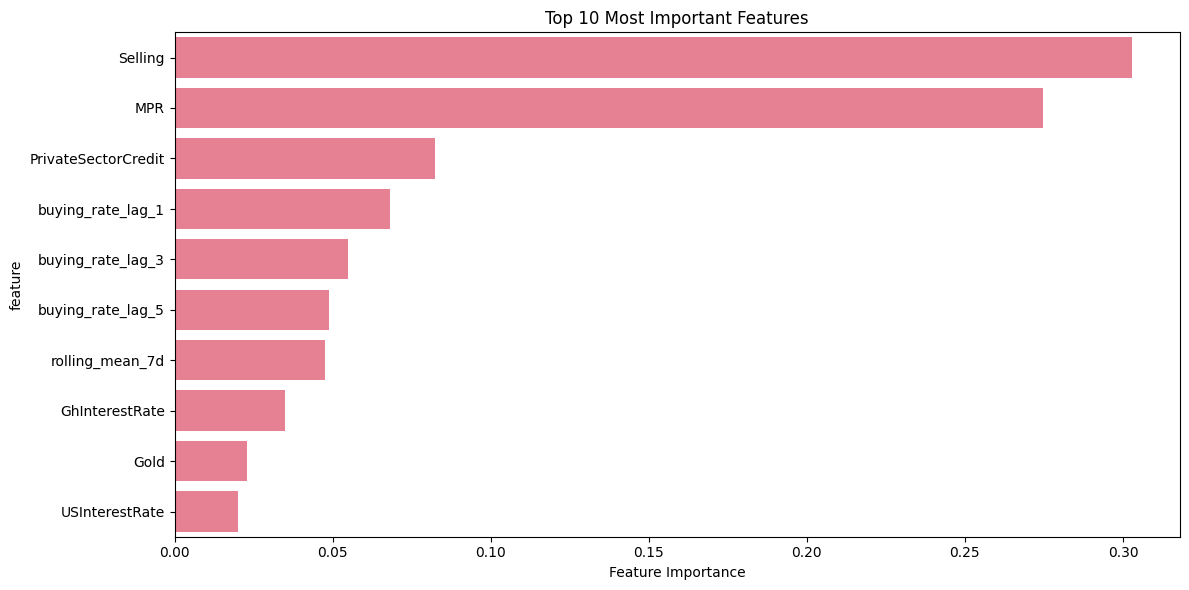

In [11]:
# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print("-" * 50)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

# Create a DataFrame with actual vs predicted values
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Actual'], label='Actual', color='blue')
plt.plot(results.index, results['Predicted'], label='Predicted', color='red')
plt.title('Actual vs Predicted GHS/USD Exchange Rates')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature importance plot
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

## 5. Model Tuning with Cross-Validation

Let's improve our model using cross-validation and hyperparameter tuning:

In [12]:
# Define parameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Function to evaluate model with cross-validation
def evaluate_model(params):
    model = xgb.XGBRegressor(**params, random_state=42)
    cv_scores = []

    for train_idx, val_idx in tscv.split(X_train_scaled):
        # Split data
        X_train_cv = X_train_scaled[train_idx]
        y_train_cv = y_train.iloc[train_idx]
        X_val_cv = X_train_scaled[val_idx]
        y_val_cv = y_train.iloc[val_idx]

        # Train and evaluate
        model.fit(X_train_cv, y_train_cv)
        predictions = model.predict(X_val_cv)
        rmse = np.sqrt(mean_squared_error(y_val_cv, predictions))
        cv_scores.append(rmse)

    return np.mean(cv_scores)

# Find best parameters (simplified grid search)
best_rmse = float('inf')
best_params = None

for max_depth in param_grid['max_depth']:
    for lr in param_grid['learning_rate']:
        for n_est in param_grid['n_estimators']:
            for mcw in param_grid['min_child_weight']:
                for ss in param_grid['subsample']:
                    params = {
                        'max_depth': max_depth,
                        'learning_rate': lr,
                        'n_estimators': n_est,
                        'min_child_weight': mcw,
                        'subsample': ss
                    }

                    current_rmse = evaluate_model(params)

                    if current_rmse < best_rmse:
                        best_rmse = current_rmse
                        best_params = params

print("Best Parameters Found:")
print("-" * 50)
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"\nBest CV RMSE: {best_rmse:.4f}")

Best Parameters Found:
--------------------------------------------------
max_depth: 7
learning_rate: 0.1
n_estimators: 100
min_child_weight: 3
subsample: 1.0

Best CV RMSE: 0.4838


## 6. Final Model Training and Evaluation

Let's train our final model with the best parameters and evaluate its performance:

Final Model Performance Metrics:
--------------------------------------------------
RMSE: 0.2083
MAE: 0.1501
R2 Score: 0.0719


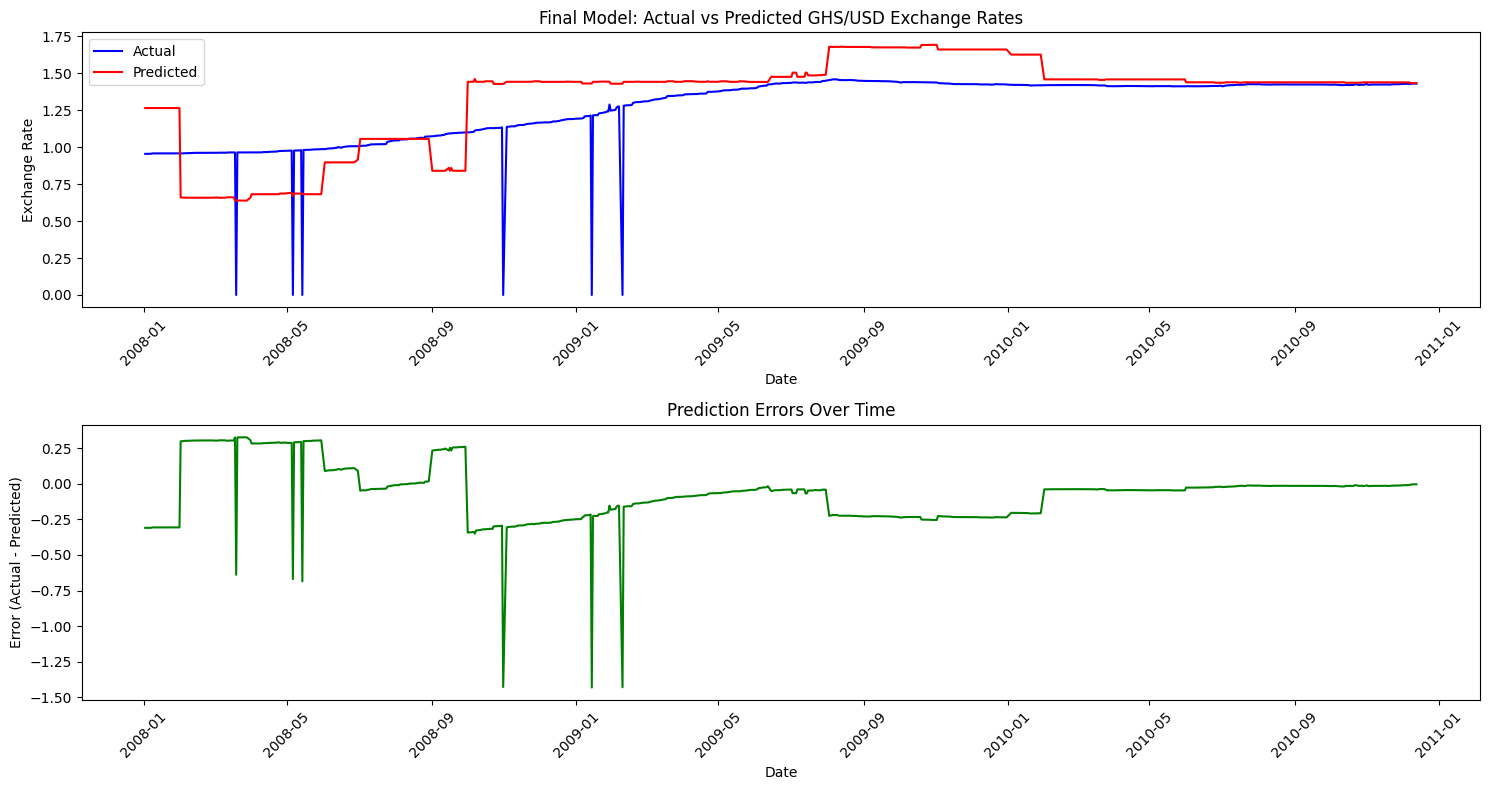

In [14]:
# Train final model with best parameters
final_model = xgb.XGBRegressor(**best_params, random_state=42)
final_model.fit(X_train_scaled, y_train)

# Make predictions
final_predictions = final_model.predict(X_test_scaled)

# Calculate final metrics
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_mae = mean_absolute_error(y_test, final_predictions)
final_r2 = r2_score(y_test, final_predictions)

print("Final Model Performance Metrics:")
print("-" * 50)
print(f"RMSE: {final_rmse:.4f}")
print(f"MAE: {final_mae:.4f}")
print(f"R2 Score: {final_r2:.4f}")

# Create final results visualization
final_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': final_predictions
})

# Plot final results
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(final_results.index, final_results['Actual'], label='Actual', color='blue')
plt.plot(final_results.index, final_results['Predicted'], label='Predicted', color='red')
plt.title('Final Model: Actual vs Predicted GHS/USD Exchange Rates')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.xticks(rotation=45)

# Plot prediction errors
plt.subplot(2, 1, 2)
errors = final_results['Actual'] - final_results['Predicted']
plt.plot(final_results.index, errors, color='green')
plt.title('Prediction Errors Over Time')
plt.xlabel('Date')
plt.ylabel('Error (Actual - Predicted)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Save predictions to CSV
# final_results.to_csv('fx_outputs/xgb_predictions.csv')